In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam

In [2]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [3]:
# classes for data loading and preprocessing
class CamVidDataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
    
    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=CLASSES, 
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        return image, mask
        
    def __len__(self):
        return len(self.ids) 

In [4]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [5]:
dataset = CamVidDataset(x_train_dir, y_train_dir)
print(len(dataset))
image, mask = dataset[5]
print(f'Image shape: {image.shape}')
print(f'Mask shape: {mask.shape}')

368
Image shape: (360, 480, 3)
Mask shape: (360, 480, 13)


In [6]:
CLASSES = ['car', 'pedestrian', 'sky', 'tree', 'road', 'building']

Image shape: (360, 480, 3)
Mask shape: (360, 480, 7)


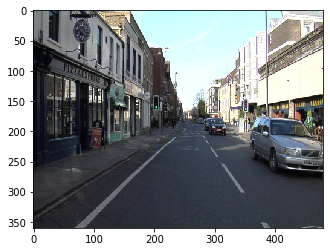

In [7]:
dataset = CamVidDataset(x_train_dir, y_train_dir, classes=CLASSES)
image, mask = dataset[50]

print(f'Image shape: {image.shape}')
plt.imshow(image)
print(f'Mask shape: {mask.shape}')

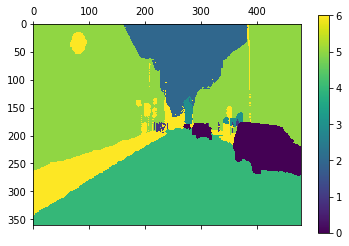

0 car
1 pedestrian
2 sky
3 tree
4 road
5 building


In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
color_ax = ax.matshow(np.argmax(mask, axis=-1))
fig.colorbar(color_ax)
plt.show()

# this will tell us what number and hence color, corresponds to what class
for i, the_class in enumerate(CLASSES):
    print(i, the_class)

In [9]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [10]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    outputs = Conv2D(n_filters*1, (1, 1), activation='softmax') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
# Define the input shape for our model to train on 
# U-Net input height and width must be a factor of 16
INPUT_HEIGHT = 352
INPUT_WIDTH = 480
N_CHANNELS = 3
input_img = keras.Input((INPUT_HEIGHT, INPUT_WIDTH, N_CHANNELS), name='img')
# create model
model = get_unet(input_img, n_filters=len(CLASSES) + 1, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

In [ ]:
def crop_image(height, width, image):
    cropped_image = image[:height, :width, :]
    return cropped_image

In [ ]:
class CamVidDataGenerator(keras.utils.Sequence):
    """Load batches of data from CamVidDataset
        refer to this article on how to create a custom data generator: 
        https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    Args:
        dataset: instance of CamVidDataset class for image loading and preprocessing.
        batch_size: Number of images in each batch.
        dim: Tuple of image height and width
        n_channels: Num of image channels
        n_classes: Num of label classes
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, dataset, batch_size=32, dim=(352, 480), n_channels=3,
                 n_classes=7, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __getitem__(self, index):
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]

        # Generate data
        for i, ID in enumerate(indexes):
            image, mask = self.dataset[ID]
            X[i,] = crop_image(*self.dim, image)
            y[i] = crop_image(*self.dim, mask)

        return X, y

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        self.indexes = np.arange(len(self.dataset))
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)  

In [1]:
# Dataset for train images
train_dataset = CamVidDataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
)

# Dataset for validation images
valid_dataset = CamVidDataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
)

# Parameters
BATCH_SIZE = 8 # change this to what your computer can handle
params = {'batch_size': BATCH_SIZE,
          'dim': (INPUT_HEIGHT, INPUT_WIDTH),
          'n_channels': N_CHANNELS,
          'n_classes': len(CLASSES)+1,
          'shuffle': True}

# Generators
training_generator = CamVidDataGenerator(train_dataset, **params)
validation_generator = CamVidDataGenerator(valid_dataset, **params)

NameError: name 'CamVidDataset' is not defined

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

EPOCHS = 100 # change this to what you want

# Train model on dataset
# ModelCheckpoint will automatically save the best model
# EarlyStopping will automatically stop when it stops improving
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=EPOCHS,
                    callbacks=[ModelCheckpoint(filepath='./ckpt.hdf5',
                                               monitor='val_accuracy',
                                               save_best_only=True,
                                               verbose=1),
                               EarlyStopping(monitor='val_accuracy',
                                             patience=10,
                                             verbose=1)])